## Notetook to plot Knowledge graph on sample text

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

import random
import argparse
import torch
import pandas as pd
from data.loader import DataLoader, get_data
from model.rnn import SubjectObjectRelationModel
from utils import torch_utils, constant
from utils.vocab import Vocab
import spacy
import json

In [3]:
model_dir='saved_models/00' # Directory of the model
model='best_model.pt' # Name of the model file
data_dir= 'dataset'
dataset= 'sample_json'
seed=1234
cuda = False #torch.cuda.is_available()
cpu = True

torch.manual_seed(seed)
random.seed(1234)
# if cpu:
#     cuda = False
# elif cuda:
#     torch.cuda.manual_seed(seed)

cpu = True
# cuda = False

In [4]:
# load opt
model_file = model_dir + '/' + model
print("Loading model from {}".format(model_file))


Loading model from saved_models/00/best_model.pt


In [5]:
#load trained model
opt = torch_utils.load_config(model_file)
model = SubjectObjectRelationModel(opt)
model.load(model_file)

Finetune all embeddings.


In [6]:
# load spacy model
spacy_model = spacy.load("en_core_web_lg")

## Provide sample text here and run all cells below (Cells->Run All Below)

In [7]:
sample_text = """
Documents Assist\n\nFlorida Cheap Divorce - Simple Divorce $280 flat fee - No Court Divorce\nEstablished in 2006.\nAfter a few years working as an Independent Associate of Legal Shield, formerly known as Pre-Paid Legal, Yamil Fuentes made it her mission to help her clients take advantage of their access to the legal system. After going through her own personal divorce she realized there was a need of affordable divorce services in the State of Florida.\nWhen she founded Apex Legal Document Preparation Services she became a Premium Member of the FALDP (Florida Association of Legal Document Preparers) and educated herself on the different types of divorce been offered across the State of Florida and learned from the best in the industry of legal document preparation services.\nThrough her membership she embarked on a journey to learn how to make the divorce process as easy as possible for her clients, making her company the most sought after divorce preparer in Florida touting the following service 'Express Divorce - 30 Days with No Court Hearing'.\nApex has now divorced hundreds of people.\nPassionate about divorcing people in the quickest and less painful manner. She has mastered the art of preparing any type of divorce in the State of Florida. Many of her clients are in the South Florida area but she is not limited to these clients.
"""

In [8]:
# prepare json for evaluation on model
sample_json = {
    "fold": 3,
    "source": "Custom Knowledge Graph",
    "documentId": "9999999",
    "documentText": sample_text
}
passages = []
for sent in spacy_model(sample_text).sents:
    passage = {"passageId": sample_json["documentId"] + ":" + str(sent.start_char) + ":" + str(sent.end_char),
               "exhaustivelyAnnotatedProperties": [],
               "passageStart": sent.start_char,
               "passageEnd": sent.end_char,
               "passageText": sent.text,
               "facts": []}
    passages.append(passage)

sample_json["passages"] = passages

# save sample text as json
with open(opt['data_dir'] + '/sample_json.json', 'w') as fout:
    fout.write(json.dumps(sample_json))

In [9]:
# load vocab
vocab_file = model_dir + '/vocab.pkl'
vocab = Vocab(vocab_file, load=True)
assert opt['vocab_size'] == vocab.size, "Vocab size must match that in the saved model."

Vocab size 16627 loaded from file


In [10]:
# load data
data_file = opt['data_dir'] + '/{}.json'.format(dataset)
print("Loading data from {} with batch size {}...".format(data_file, opt['batch_size']))
batch = DataLoader(data_file, opt['batch_size'], opt, vocab, spacy_model, evaluation=True)


Loading data from dataset/sample_json.json with batch size 32...
3 batches created for dataset/sample_json.json


In [11]:
# predict
predictions = []
all_probs = []
for i, b in enumerate(batch):
    preds, probs, _ = model.predict(b)
    predictions += preds
    all_probs += probs

# class to label
class2id = dict([(v, k) for k, v in constant.ID_TO_CLASS.items()])
id2label = dict([(v, k) for k, v in constant.LABEL_TO_ID.items()])
predictions = [class2id[p] for p in predictions]
predictions = [id2label[p] for p in predictions]



In [12]:
# sync predictions of passages to documents
data = get_data(data_file, spacy_model, evaluation=True)
prediction_data = []
for index, d in enumerate(data):
    d["propertyName"] = predictions[index]
    # remove no relation entities
    if predictions[index] not in ["NO_RELATION"]:
        d["propertyId"] = str(constant.LABEL_TO_ID[predictions[index]])
        d["factId"] = d["factId"][:-1] + d["propertyId"]
        d["humanReadable"] = "<" + "> <".join([d["subjectText"], d["propertyName"], d["objectText"]]) + ">"
        prediction_data.append(d)

In [13]:
pairs_df = pd.DataFrame(prediction_data)
pairs_df

,factId,propertyId,subjectStart,subjectEnd,subjectText,subjectUri,objectStart,objectEnd,objectText,passageText,passageStart,passageEnd,propertyName,humanReadable
0,9999999:217:230:169:181:3,3,217,230,Yamil Fuentes,,169,181,Legal Shield,After a few years working as an Independent As...,112,322,EMPLOYEE_OR_MEMBER_OF,<Yamil Fuentes> <EMPLOYEE_OR_MEMBER_OF> <Legal...
1,9999999:236:238:169:181:3,3,236,238,it,,169,181,Legal Shield,After a few years working as an Independent As...,112,322,EMPLOYEE_OR_MEMBER_OF,<it> <EMPLOYEE_OR_MEMBER_OF> <Legal Shield>
2,9999999:259:270:169:181:3,3,259,270,her clients,,169,181,Legal Shield,After a few years working as an Independent As...,112,322,EMPLOYEE_OR_MEMBER_OF,<her clients> <EMPLOYEE_OR_MEMBER_OF> <Legal S...
3,9999999:368:371:445:452:11,11,368,371,she,,445,452,Florida,After going through her own personal divorce s...,323,454,PLACE_OF_RESIDENCE,<she> <PLACE_OF_RESIDENCE> <Florida>
4,9999999:459:462:471:511:3,3,459,462,she,,471,511,Apex Legal Document Preparation Services,When she founded Apex Legal Document Preparati...,454,781,EMPLOYEE_OR_MEMBER_OF,<she> <EMPLOYEE_OR_MEMBER_OF> <Apex Legal Docu...
5,9999999:459:462:577:601:3,3,459,462,she,,577,601,Legal Document Preparers,When she founded Apex Legal Document Preparati...,454,781,EMPLOYEE_OR_MEMBER_OF,<she> <EMPLOYEE_OR_MEMBER_OF> <Legal Document ...
6,9999999:459:462:616:623:9,9,459,462,she,,616,623,herself,When she founded Apex Legal Document Preparati...,454,781,EDUCATED_AT,<she> <EDUCATED_AT> <herself>
7,9999999:459:462:691:698:11,11,459,462,she,,691,698,Florida,When she founded Apex Legal Document Preparati...,454,781,PLACE_OF_RESIDENCE,<she> <PLACE_OF_RESIDENCE> <Florida>
8,9999999:459:462:744:779:9,9,459,462,she,,744,779,legal document preparation services,When she founded Apex Legal Document Preparati...,454,781,EDUCATED_AT,<she> <EDUCATED_AT> <legal document preparatio...
9,9999999:804:807:969:976:11,11,804,807,she,,969,976,Florida,Through her membership she embarked on a journ...,781,1058,PLACE_OF_RESIDENCE,<she> <PLACE_OF_RESIDENCE> <Florida>


In [14]:
# draw knowledge graph
def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subjectText', 'objectText',
                                      create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(30, 30), dpi=200)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
    )
    labels = dict(zip(list(zip(pairs.subjectText, pairs.objectText)),
                      pairs['propertyName'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

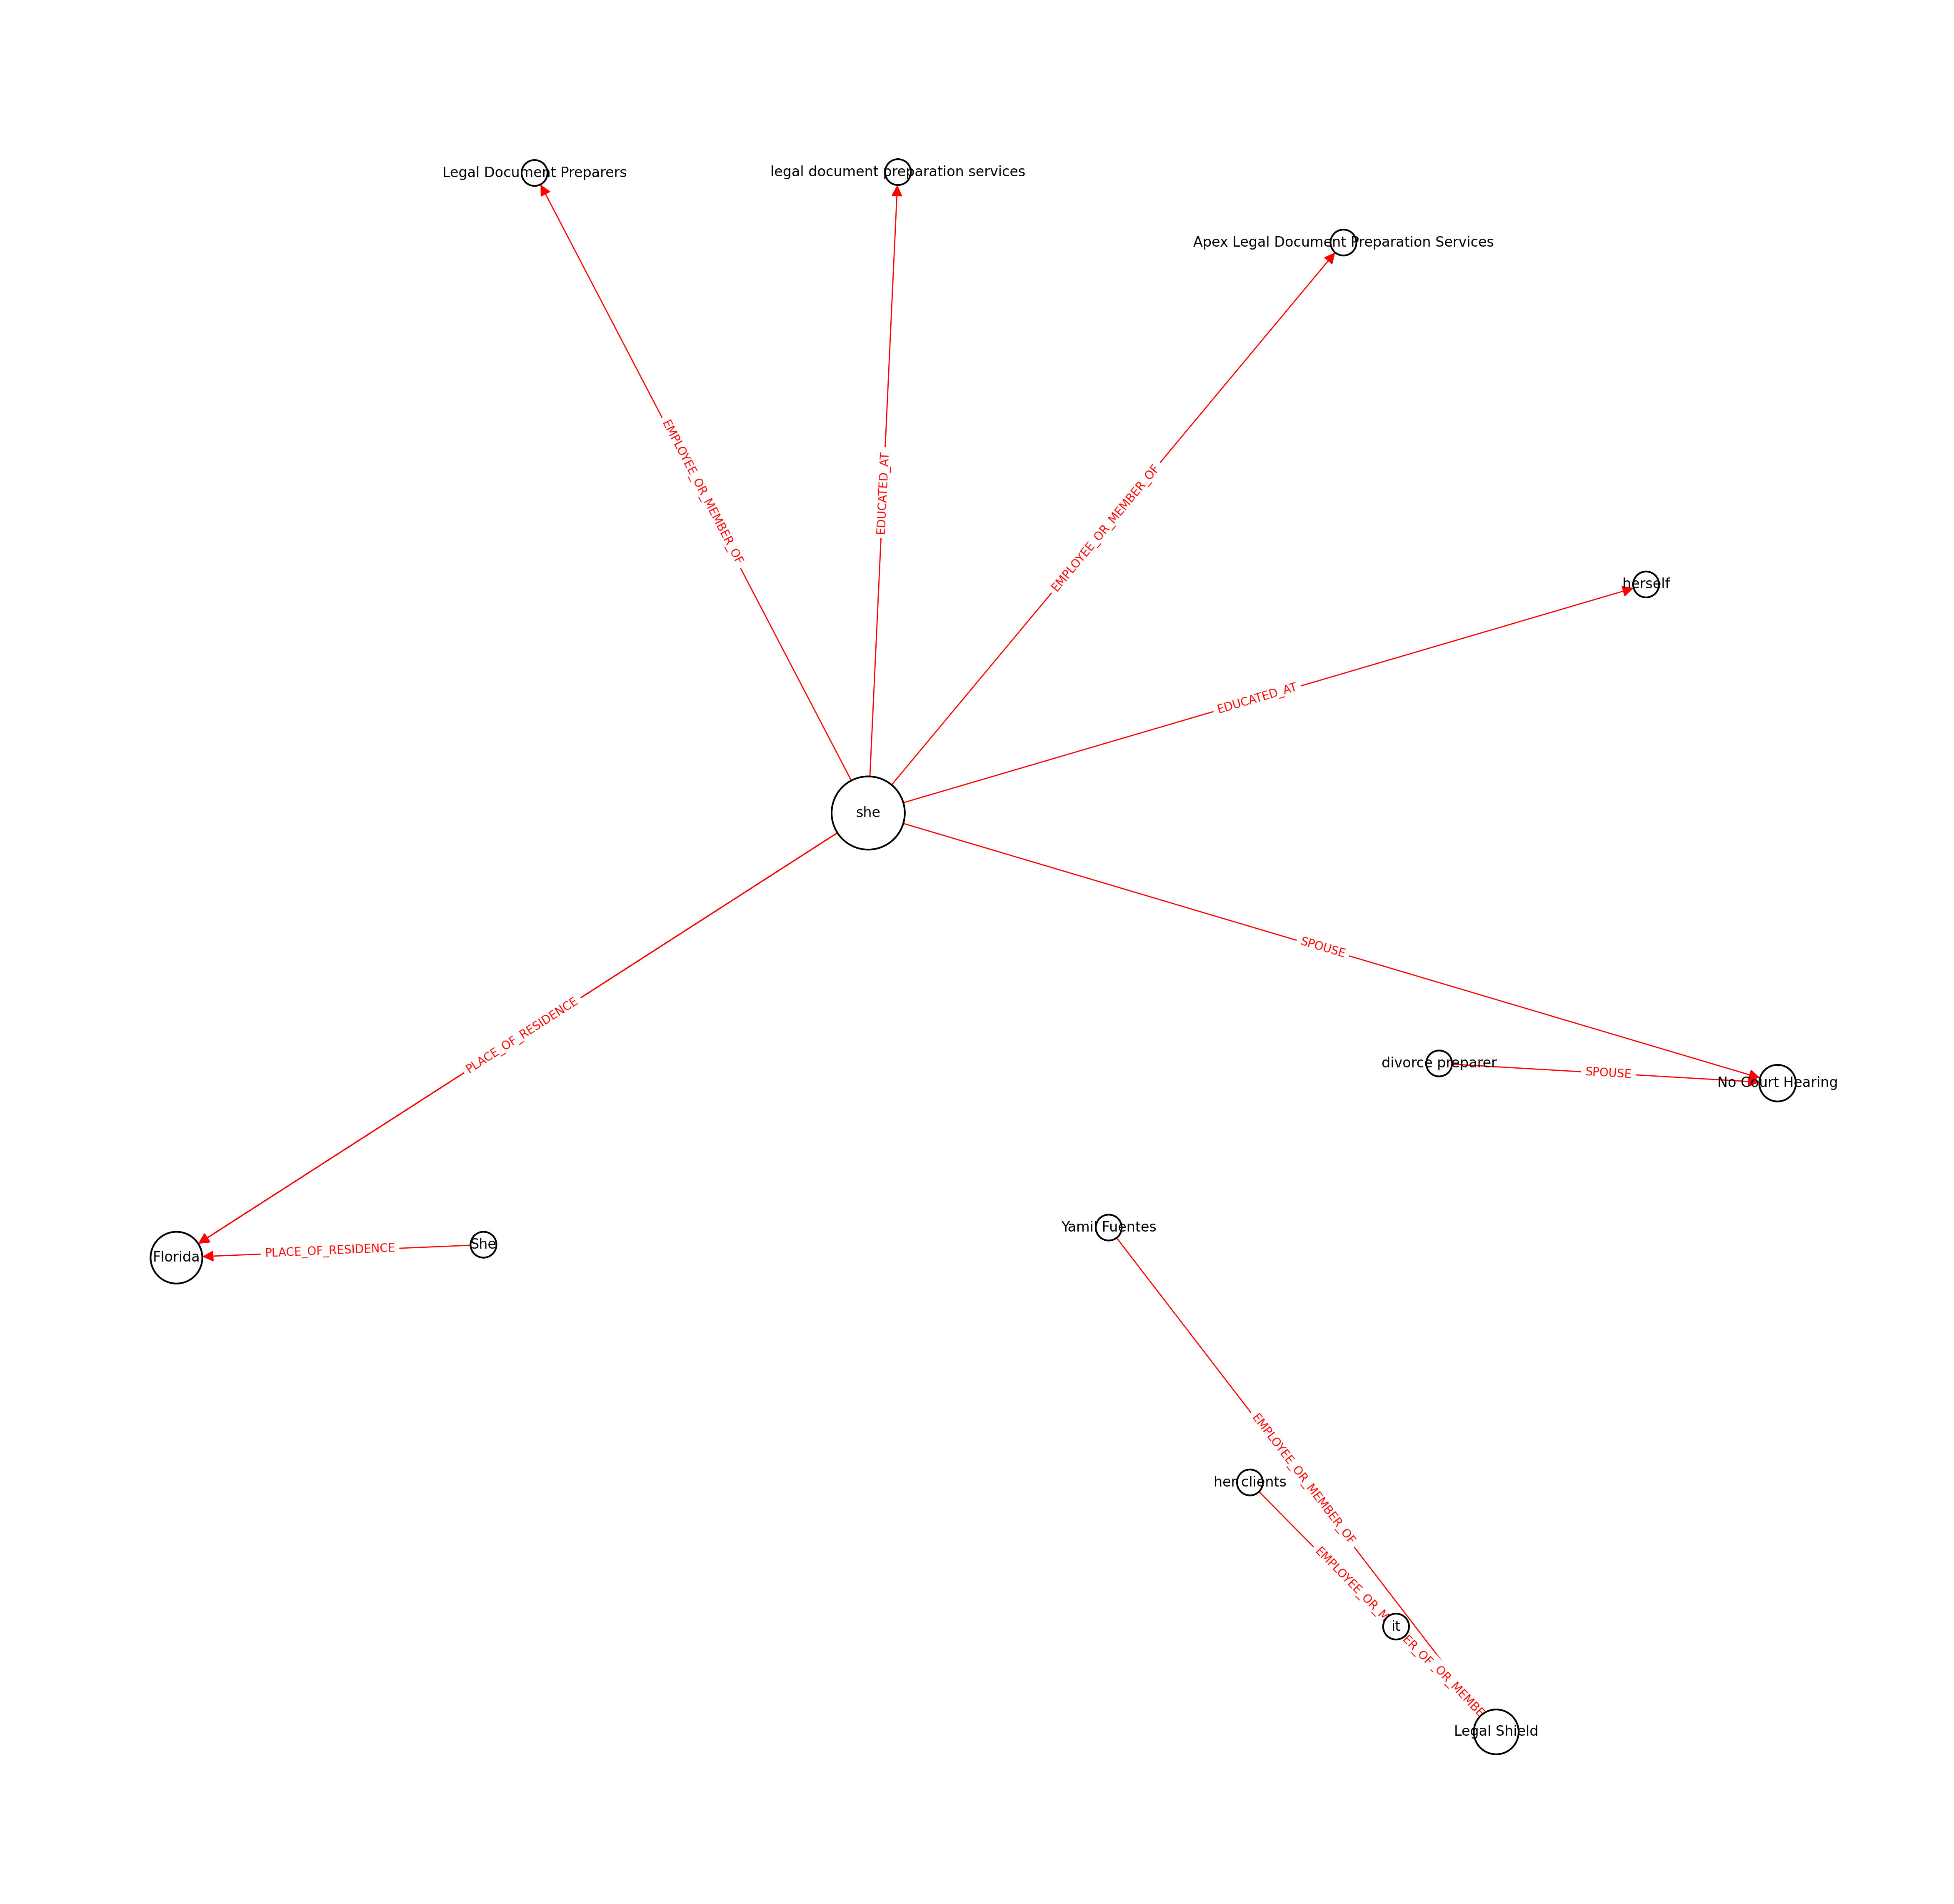

In [15]:
# plot Knowledge graph
draw_kg(pairs_df)